# ResNet-50

In [4]:
import os
import time
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, Bottleneck
from torch.optim.lr_scheduler import OneCycleLR

# ------------------- CONFIG -------------------
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
TRAIN_SPLIT = os.path.join(BASE_PATH, 'train_split.json')
VAL_SPLIT   = os.path.join(BASE_PATH, 'val_split.json')
CLASS_WEIGHTS_PATH = os.path.join(BASE_PATH, 'class_weights.json')
SAVED_MODEL_DIR    = "C:/Users/User/Desktop/saved_model"
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

NUM_CLASSES        = 4   # Soil, Bedrock, Sand, Big Rock
BATCH_SIZE         = 16
EPOCHS             = 15
BASE_LR            = 3e-3  # Lower bound for LR
MAX_LR             = 3e-2  # Upper bound for OneCycleLR
L2_REGULARIZATION  = 1e-5
PATIENCE           = 5
MIN_DELTA          = 1e-5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ---------------------------------------------

# ----------------- DATA LOADING -------------
def load_splits(split_path):
    with open(split_path, 'r') as f:
        return json.load(f)

train_split = load_splits(TRAIN_SPLIT)
val_split   = load_splits(VAL_SPLIT)

# Load class weights
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_json = json.load(f)
class_weights = torch.tensor(class_weights_json["class_weights"], dtype=torch.float32)

class RealMarsDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list[dict]): List of dictionaries with 'image' and 'mask' keys
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]['image']
        mask_path  = self.data[idx]['mask']

        # Load and preprocess image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            image = np.zeros((256, 256, 3), dtype=np.float32)
        else:
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, (256, 256))
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # (C,H,W)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
        else:
            mask = mask.astype(np.int64)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        # Replace 255 with -1 for ignore
        mask[mask == 255] = -1

        # One-hot encoding
        mask_one_hot = torch.zeros((NUM_CLASSES, mask.shape[0], mask.shape[1]), dtype=torch.float32)
        for c in range(NUM_CLASSES):
            mask_class = (mask == c).astype(np.float32)
            mask_one_hot[c] = torch.from_numpy(mask_class)

        return image, torch.tensor(mask, dtype=torch.long), mask_one_hot

train_dataset = RealMarsDataset(train_split)
val_dataset   = RealMarsDataset(val_split)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

############################################
#               Hybrid Loss
############################################
def hybrid_loss(pred, target, target_one_hot, class_weights, ignore_index=-1):
    """
    Weighted Cross-Entropy (WCE) + Dice + Tversky + Focal loss combined.
    """
    import torch.nn as nn

    # Weighted Cross-Entropy
    valid_target = target.clone()
    valid_target[valid_target == ignore_index] = 0
    wce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)(pred, valid_target)

    # Softmax
    pred_softmax = torch.softmax(pred, dim=1)

    # Dice Loss
    dice_num = 2 * (pred_softmax * target_one_hot).sum(dim=(2, 3))
    dice_den = (pred_softmax + target_one_hot).sum(dim=(2, 3)) + 1e-6
    dice = 1 - (dice_num / dice_den).mean()

    # Tversky Loss
    alpha, beta = 0.6, 0.4
    true_pos = (pred_softmax * target_one_hot).sum(dim=(2, 3))
    false_neg = (target_one_hot * (1 - pred_softmax)).sum(dim=(2, 3))
    false_pos = ((1 - target_one_hot) * pred_softmax).sum(dim=(2, 3))
    tversky_index = true_pos / (true_pos + alpha * false_neg + beta * false_pos + 1e-6)
    tversky = 1 - tversky_index.mean()

    # Focal Loss (gamma=2)
    focal = -(target_one_hot * ((1 - pred_softmax)**2) * torch.log(pred_softmax + 1e-6)).mean()

    return wce_loss + dice + tversky + focal

###########################################
#         TruncatedResNet50
###########################################
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, Bottleneck

class ResNet50Encoder(ResNet):
    """
    A ResNet-50-based encoder that omits the final layer4 (together with fc, avgpool)
    to reduce training cost. Pretrained weights are NOT loaded here to avoid recursion.
    """
    def __init__(self):
        # Standard ResNet-50: Bottleneck layers = [3,4,6,3].
        super().__init__(block=Bottleneck, layers=[3, 4, 6, 3])

        # Remove final stage and classification layers
        del self.layer4
        del self.fc
        del self.avgpool

    def forward(self, x):
        """
        Returns intermediate features from stage1,2,3:
          conv1->bn1->relu->maxpool -> layer1 -> layer2 -> layer3
        Output shapes:
          layer1: [B, 256,  H/4,  W/4]
          layer2: [B, 512,  H/8,  W/8]
          layer3: [B, 1024, H/16, W/16]
        """
        # Initial layers
        x = self.conv1(x)       # => [B,64,H/2,W/2]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)     # => [B,64,H/4,W/4]

        # layer1 => [B,256,H/4,W/4]
        f1 = self.layer1(x)

        # layer2 => [B,512,H/8,W/8]
        f2 = self.layer2(f1)

        # layer3 => [B,1024,H/16,W/16]
        f3 = self.layer3(f2)

        return f1, f2, f3


###########################################
#         DecoderNoLayer4
###########################################
class ResNet50Decoder(nn.Module):
    """
    Decoder for truncated ResNet-50 outputs up to layer3 => 1024 channels.
    We upsample back to 256x256. 
    Skips from f1(256ch,H/4) & f2(512ch,H/8).
    """
    def __init__(self, num_classes=4):
        super().__init__()
        # up1 => 1024->512 => [B,512,H/8->H/4]
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(512)

        self.merge1 = nn.Conv2d(512+512, 512, kernel_size=1, bias=False)
        self.bn_merge1 = nn.BatchNorm2d(512)

        # up2 => 512->256 => H/4->H/2
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)

        self.merge2 = nn.Conv2d(256+256, 256, kernel_size=1, bias=False)
        self.bn_merge2 = nn.BatchNorm2d(256)

        # up3 => 256->128 => H/2->H
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        # final => 128->64->... optionally do one more if needed
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, f1, f2, f3):
        """
        f3 => [B,1024,H/16,W/16]
        f2 => [B,512,H/8,W/8]
        f1 => [B,256,H/4,W/4]
        """
        # up1 => => [B,512,H/8,W/8]
        x = self.up1(f3)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        # merge skip f2 => => [B,512+512=1024,H/8,W/8]
        x = torch.cat([x, f2], dim=1)
        x = self.merge1(x)
        x = self.bn_merge1(x)
        x = F.relu(x, inplace=True)

        # up2 => => [B,256,H/4,W/4]
        x = self.up2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        # merge skip f1 => => [B,256+256=512,H/4,W/4]
        x = torch.cat([x, f1], dim=1)
        x = self.merge2(x)
        x = self.bn_merge2(x)
        x = F.relu(x, inplace=True)

        # up3 => => [B,128,H/2,W/2]
        x = self.up3(x)
        x = self.bn3(x)
        x = F.relu(x, inplace=True)

        # up4 => => [B,64,H,W] => 256×256 final
        x = self.up4(x)
        x = self.bn4(x)
        x = F.relu(x, inplace=True)

        # final => => [B,num_classes,256,256]
        logits = self.final_conv(x)
        return logits

###########################################
#         Final TruncatedResNet50Seg
###########################################
class ResNet50(nn.Module):
    """
    Combines the truncated ResNet-50 (no layer4) with a 
    transposed-conv decoder. 
    """
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        self.encoder = ResNet50Encoder()
        self.decoder = ResNet50Decoder(num_classes=num_classes, )

    def forward(self, x):
        f1, f2, f3 = self.encoder(x)
        logits = self.decoder(f1, f2, f3)
        return logits

# ---------------- TRAIN FUNCTION -------------
def train_model(
    model, train_loader, val_loader, base_lr, max_lr,
    num_epochs, save_path, early_stopping_patience=5
):
    import math
    from torch.optim import Adam
    from torch.optim.lr_scheduler import OneCycleLR

    # Move model to device
    model.to(DEVICE)

    # Define optimizer (e.g., Adam)
    optimizer = Adam(model.parameters(), lr=base_lr, weight_decay=L2_REGULARIZATION)

    # OneCycleLR needs total steps
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * num_epochs

    # Setup OneCycleLR
    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        pct_start=0.3  # portion of cycle spent increasing LR
    )

    best_val_loss = float('inf')
    early_stopping_counter = 0

    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    def mean_iou(pred, target, num_classes):
        """Calculate Mean IoU."""
        pred = torch.argmax(pred, dim=1)
        ious = []
        for cls in range(num_classes):
            intersection = ((pred == cls) & (target == cls)).sum().item()
            union = ((pred == cls) | (target == cls)).sum().item()
            if union > 0:
                ious.append(intersection / union)
        return np.mean(ious) if ious else 0.0

    curr_lr = optimizer.param_groups[0]['lr']  # Keep track of current LR

    for epoch in range(num_epochs):
        # Manually adjust LR every 2 epochs by factor=0.7
        if epoch > 0 and epoch % 2 == 0:
            curr_lr = curr_lr * 0.7
            for param_group in optimizer.param_groups:
                param_group['lr'] = curr_lr
            print(f"Learning Rate decayed to {curr_lr:.6f} at epoch {epoch}")

        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, masks, masks_one_hot in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = hybrid_loss(outputs, masks, masks_one_hot, class_weights)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Accuracy calculation
            preds = outputs.argmax(dim=1)
            valid_indices = (masks != -1)  # ignore index
            train_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
            train_total   += valid_indices.sum().item()

        # Compute training metrics
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0.0

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, masks, masks_one_hot in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)
                outputs = model(images)
                loss = hybrid_loss(outputs, masks, masks_one_hot, class_weights)
                val_loss += loss.item()

                # Accuracy calculation
                preds = outputs.argmax(dim=1)
                valid_indices = (masks != -1)
                val_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
                val_total   += valid_indices.sum().item()

        val_loss      /= len(val_loader)
        val_accuracy  = val_correct / val_total if val_total > 0 else 0.0

        # Step the ReduceLROnPlateau with the validation loss
        scheduler.step(val_loss)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, LR: {curr_lr:.6f}")

        # Save metrics to history
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

    return history

# ---------------- PLOT LEARNING CURVES --------------
def plot_learning_curves(history):
    """Plot training and validation loss, accuracy using the stored `history` dict."""
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label="Train Loss", marker='o')
    plt.plot(history['val_loss'], label="Validation Loss", marker='o')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label="Train Accuracy", marker='o')
    plt.plot(history['val_accuracy'], label="Validation Accuracy", marker='o')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# ---------------- MAIN SCRIPT ----------------
if __name__ == "__main__":
    # 1) Build truncated ResNet-50 model
    model = ResNet50(num_classes=NUM_CLASSES, pretrained=True)

    # 2) Train with OneCycleLR
    EPOCHS = 15
    base_lr = BASE_LR  # e.g., 3e-3
    max_lr = MAX_LR    # e.g., 3e-2
    save_path = os.path.join(SAVED_MODEL_DIR, 'ResNet50.pth')

    history = train_model(
        model,
        train_loader,
        val_loader,
        base_lr=base_lr,
        max_lr=max_lr,
        num_epochs=EPOCHS,
        save_path=save_path,
        early_stopping_patience=PATIENCE
    )

    # 3) Plot training curves
    plot_learning_curves(history)

    print("Training complete. Results have been saved.")


TypeError: ResNet50Decoder.__init__() got an unexpected keyword argument 'dropout'

Model evaluation

Classification Report:
              precision    recall  f1-score   support

        Soil     0.8523    0.9599    0.9029  32495798
     Bedrock     0.9760    0.8449    0.9057  43578871
        Sand     0.8745    0.8977    0.8859  10873451
    Big Rock     0.2679    0.7830    0.3993    761427

    accuracy                         0.8935  87709547
   macro avg     0.7427    0.8714    0.7734  87709547
weighted avg     0.9114    0.8935    0.8978  87709547



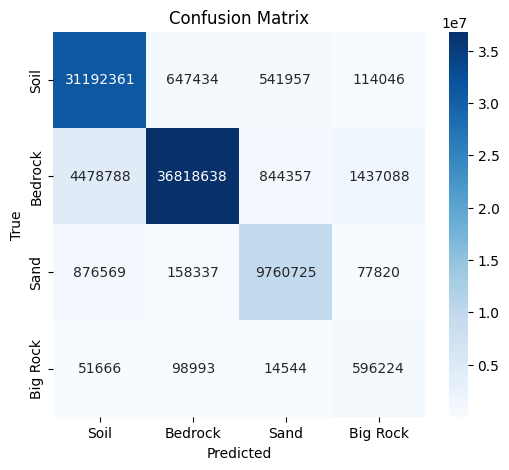

Per-Class IoU:
  Soil: 0.8230
  Bedrock: 0.8277
  Sand: 0.7952
  Big Rock: 0.2494
Mean IoU: 0.6738


In [2]:
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your test split and define a DataLoader similar to how you do it for train/val
#    (Assuming you have test_split.json or something similar).
test_split_path = os.path.join(BASE_PATH, "test_split.json")

# Example RealMarsDataset usage for the test set (reusing the same class from your code)
test_split_data = load_splits(test_split_path)
test_dataset = RealMarsDataset(test_split_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 2. Load the trained model and set it to eval mode
model = ResNet50(num_classes=NUM_CLASSES)
model_path = os.path.join(SAVED_MODEL_DIR, 'ResNet50.pth')
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# 3. Inference on the test set and gather predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks, _ in test_loader:  # We don't necessarily need masks_one_hot for evaluation
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(dim=1)  # shape: (batch_size, H, W)

        # Move to CPU
        preds_np  = preds.cpu().numpy()
        masks_np  = masks.cpu().numpy()

        # Flatten them, but exclude the -1 ignore pixels
        for i in range(preds_np.shape[0]):
            valid_indices = (masks_np[i] != -1)  # mask is -1 => ignore
            valid_preds   = preds_np[i][valid_indices]
            valid_targets = masks_np[i][valid_indices]
            all_preds.extend(valid_preds.tolist())
            all_targets.extend(valid_targets.tolist())

# 4. Classification report (multi-class)
#    We specify the class indices and their names for interpretability:
class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]
report = classification_report(
    all_targets,
    all_preds,
    labels=[0, 1, 2, 3],
    target_names=class_names,
    digits=4
)
print("Classification Report:")
print(report)

# 5. Confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Compute class-wise and mean IoU
#    We can adapt the mean_iou approach to aggregated data here
def compute_iou(preds, targets, num_classes):
    """
    preds: list or 1D array of predicted class indices
    targets: list or 1D array of ground truth class indices
    Returns: array of IoU values for each class, plus mean IoU
    """
    ious = []
    for cls in range(num_classes):
        intersection = 0
        union = 0
        for p, t in zip(preds, targets):
            intersection += int(p == cls and t == cls)
            union        += int((p == cls) or (t == cls))
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

ious = compute_iou(all_preds, all_targets, NUM_CLASSES)
print("Per-Class IoU:")
for idx, iou_val in enumerate(ious):
    print(f"  {class_names[idx]}: {iou_val:.4f}")
mean_iou = np.nanmean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

Segmentation map prediction

Selected Image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_626267617EDR_F0771560NCAM00263M1.JPG
Ground Truth Label: C:/Users/User/Desktop/ai4mars/msl\labels\train\NLB_626267617EDR_F0771560NCAM00263M1.png


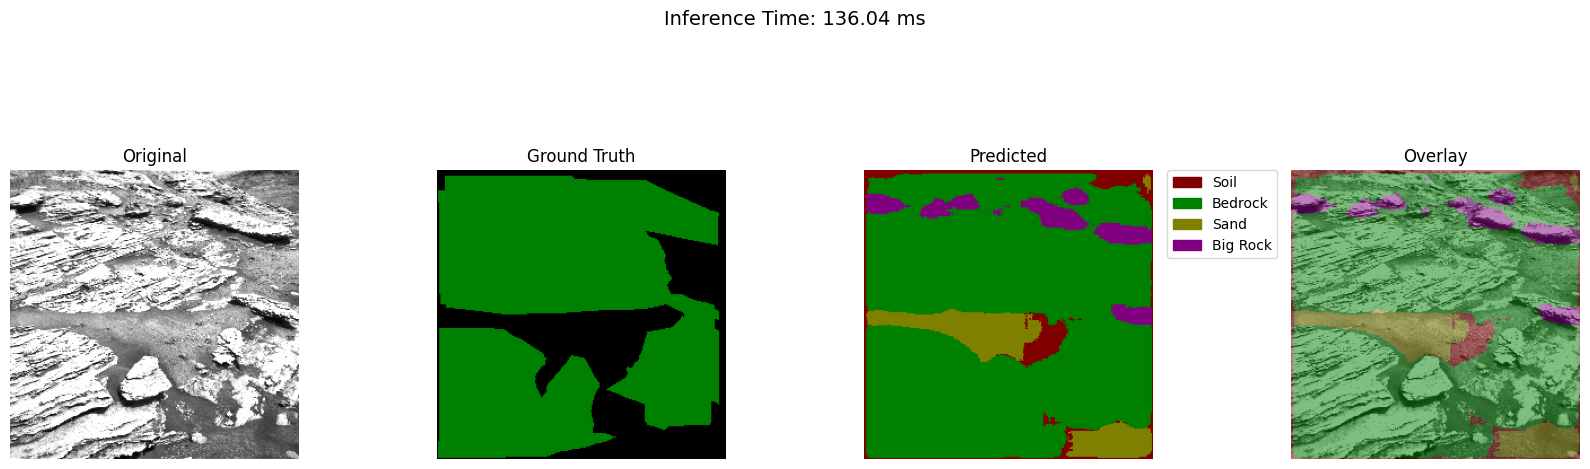

In [8]:
import os
import json
import time
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


BASE_PATH       = "C:/Users/User/Desktop/ai4mars/msl"
TEST_SPLIT      = os.path.join(BASE_PATH, "test_split.json")
SAVED_MODEL_DIR = "C:/Users/User/Desktop/saved_model"
MODEL_PATH      = os.path.join(SAVED_MODEL_DIR, "ResNet50.pth")

NUM_CLASSES     = 4
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]

# Consistent BGR color map for display
color_map = {
    0: (0, 0, 128),    # Soil
    1: (0, 128, 0),    # Bedrock
    2: (0, 128, 128),  # Sand
    3: (128, 0, 128),  # Big Rock
}

def load_test_split(test_split_path):
    with open(test_split_path, 'r') as f:
        return json.load(f)

def load_preprocess_single_image(img_path):
    """Load an image, resize to 256x256, normalize [0..1], and convert to Tensor(C,H,W)."""
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        image = np.zeros((256, 256, 3), dtype=np.float32)
    else:
        image = image.astype(np.float32) / 255.0
        image = cv2.resize(image, (256, 256))
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float()
    return image_tensor

def load_ground_truth_mask(mask_path):
    """Load ground-truth mask, resize, and return as (H,W) integer array."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
    else:
        mask = mask.astype(np.int64)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    return mask

def colorize_mask(mask):
    """
    Convert class indices in 'mask' to a BGR color image using 'color_map'.
    mask shape: (H, W), integer class IDs.
    Returns: (H,W,3) colored image.
    """
    h, w = mask.shape
    seg_vis = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, bgr in color_map.items():
        seg_vis[mask == cls_idx] = bgr
    return seg_vis

def main():
    # 1. Load test split
    test_data = load_test_split(TEST_SPLIT)
    if not test_data:
        raise ValueError("Test split is empty or missing.")

    # 2. Select an image from the test split
    image_id = 1239
    if image_id < 0 or image_id >= len(test_data):
        raise ValueError(f"Invalid image_id: {image_id}, must be between 0 and {len(test_data)-1}.")

    sample = test_data[image_id]
    image_path = sample["image"]
    mask_path  = sample["mask"]  # Ground-truth label path

    print(f"Selected Image: {image_path}")
    print(f"Ground Truth Label: {mask_path}")

    # 3. Load the trained ERFNet model
    model = ResNet50(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # 4. Preprocess the single image
    image_tensor = load_preprocess_single_image(image_path).unsqueeze(0).to(DEVICE)

    # Load original BGR image for display
    original_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_bgr is None:
        original_bgr = np.zeros((256, 256, 3), dtype=np.uint8)
    else:
        original_bgr = cv2.resize(original_bgr, (256, 256))

    # Load ground truth mask
    gt_mask = load_ground_truth_mask(mask_path)  # shape [256,256], class IDs
    gt_color = colorize_mask(gt_mask)

    # 5. Inference and measure time
    start_time = time.time()
    with torch.no_grad():
        output = model(image_tensor)  # shape [1, num_classes, 256,256]
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000

    # 6. Convert to predicted mask
    pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()
    pred_color = colorize_mask(pred_mask)

    # 7. Visualization
    # For clarity, we display 4 subplots: (1) original, (2) ground-truth, (3) predicted, (4) overlay
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    gt_rgb       = cv2.cvtColor(gt_color, cv2.COLOR_BGR2RGB)
    pred_rgb     = cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)

    # Overlay: blend original and predicted
    overlay_bgr = cv2.addWeighted(original_bgr, 0.5, pred_color, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    # Build legend patches
    patches = []
    for i, name in enumerate(class_names):
        b, g, r = color_map[i]
        color_rgb = (r/255, g/255, b/255)
        patches.append(mpatches.Patch(color=color_rgb, label=name))

    plt.figure(figsize=(16, 6))

    # Subplot 1: Original
    plt.subplot(1, 4, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis('off')

    # Subplot 2: Ground Truth
    plt.subplot(1, 4, 2)
    plt.imshow(gt_rgb)
    plt.title("Ground Truth")
    plt.axis('off')

    # Subplot 3: Predicted
    plt.subplot(1, 4, 3)
    plt.imshow(pred_rgb)
    plt.title("Predicted")
    plt.axis('off')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Subplot 4: Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(overlay_rgb)
    plt.title("Overlay")
    plt.axis('off')

    plt.suptitle(f"Inference Time: {inference_time_ms:.2f} ms", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# ResNet-50 2

Initializing ResNet50 with dropout=0.2
Initializing ResNet50Decoder with dropout=0.2


Epoch 1/15 [Val]: 100%|██████████| 151/151 [05:55<00:00,  2.36s/it]


[Epoch 1/15] Train Loss: 2.6578, Train Acc: 0.6533, Val Loss: 3.4291, Val Acc: 0.4475, LR: 0.002967
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 2/15 [Val]: 100%|██████████| 151/151 [05:43<00:00,  2.27s/it]


[Epoch 2/15] Train Loss: 2.4773, Train Acc: 0.7242, Val Loss: 2.3359, Val Acc: 0.8015, LR: 0.002870
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 3/15 [Val]: 100%|██████████| 151/151 [05:50<00:00,  2.32s/it]


[Epoch 3/15] Train Loss: 2.3924, Train Acc: 0.7537, Val Loss: 2.3457, Val Acc: 0.8111, LR: 0.002714


Epoch 4/15 [Val]: 100%|██████████| 151/151 [05:58<00:00,  2.38s/it]


[Epoch 4/15] Train Loss: 2.3502, Train Acc: 0.7663, Val Loss: 2.5706, Val Acc: 0.6301, LR: 0.002504


Epoch 5/15 [Val]: 100%|██████████| 151/151 [05:32<00:00,  2.20s/it]


[Epoch 5/15] Train Loss: 2.3211, Train Acc: 0.7774, Val Loss: 2.2516, Val Acc: 0.7720, LR: 0.002250
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 6/15 [Val]: 100%|██████████| 151/151 [05:38<00:00,  2.24s/it]


[Epoch 6/15] Train Loss: 2.2576, Train Acc: 0.7971, Val Loss: 2.3679, Val Acc: 0.7298, LR: 0.001964


Epoch 7/15 [Val]: 100%|██████████| 151/151 [05:33<00:00,  2.21s/it]


[Epoch 7/15] Train Loss: 2.2414, Train Acc: 0.8039, Val Loss: 2.1691, Val Acc: 0.8217, LR: 0.001657
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 8/15 [Val]: 100%|██████████| 151/151 [05:37<00:00,  2.24s/it]


[Epoch 8/15] Train Loss: 2.2109, Train Acc: 0.8083, Val Loss: 2.3964, Val Acc: 0.6375, LR: 0.001344


Epoch 9/15 [Val]: 100%|██████████| 151/151 [05:27<00:00,  2.17s/it]


[Epoch 9/15] Train Loss: 2.1822, Train Acc: 0.8190, Val Loss: 2.2192, Val Acc: 0.8224, LR: 0.001037


Epoch 10/15 [Val]: 100%|██████████| 151/151 [05:38<00:00,  2.24s/it]


[Epoch 10/15] Train Loss: 2.1367, Train Acc: 0.8334, Val Loss: 2.3282, Val Acc: 0.6398, LR: 0.000751


Epoch 11/15 [Val]: 100%|██████████| 151/151 [05:44<00:00,  2.28s/it]


[Epoch 11/15] Train Loss: 2.1099, Train Acc: 0.8411, Val Loss: 2.0825, Val Acc: 0.8819, LR: 0.000497
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 12/15 [Val]: 100%|██████████| 151/151 [05:55<00:00,  2.35s/it]


[Epoch 12/15] Train Loss: 2.0782, Train Acc: 0.8503, Val Loss: 2.0571, Val Acc: 0.8503, LR: 0.000287
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 13/15 [Val]: 100%|██████████| 151/151 [06:03<00:00,  2.41s/it]


[Epoch 13/15] Train Loss: 2.0561, Train Acc: 0.8555, Val Loss: 1.9958, Val Acc: 0.8538, LR: 0.000131
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 14/15 [Val]: 100%|██████████| 151/151 [05:41<00:00,  2.26s/it]


[Epoch 14/15] Train Loss: 2.0344, Train Acc: 0.8614, Val Loss: 1.9667, Val Acc: 0.8962, LR: 0.000034
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


Epoch 15/15 [Val]: 100%|██████████| 151/151 [05:35<00:00,  2.22s/it]


[Epoch 15/15] Train Loss: 2.0234, Train Acc: 0.8632, Val Loss: 1.9538, Val Acc: 0.8880, LR: 0.000001
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_2.pth


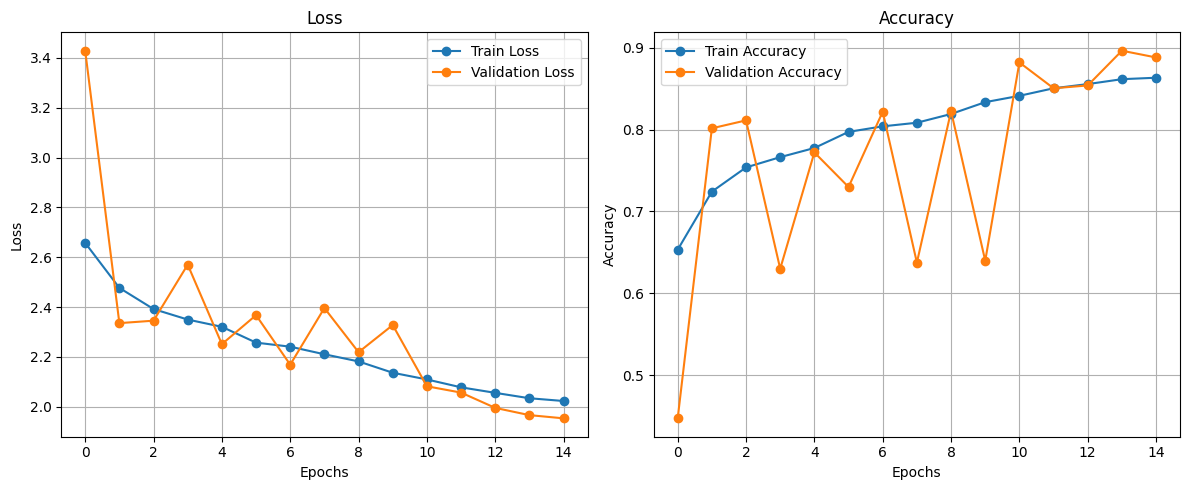

Training complete. Results have been saved.


In [12]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import torch.optim as optim
from glob import glob
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from torchvision.models.resnet import ResNet, Bottleneck
from torch.optim.lr_scheduler import CosineAnnealingLR

# ------------------- CONFIG -------------------
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
TRAIN_SPLIT = os.path.join(BASE_PATH, 'train_split.json')
VAL_SPLIT   = os.path.join(BASE_PATH, 'val_split.json')
CLASS_WEIGHTS_PATH = os.path.join(BASE_PATH, 'class_weights.json')
SAVED_MODEL_DIR    = "C:/Users/User/Desktop/saved_model"
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

NUM_CLASSES        = 4   # Soil, Bedrock, Sand, Big Rock
BATCH_SIZE         = 16
EPOCHS             = 15
LEARNING_RATE      = 3e-3
L2_REGULARIZATION  = 1e-5
PATIENCE           = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------------------------------------
# ----------------- DATA LOADING -------------
def load_splits(split_path):
    with open(split_path, 'r') as f:
        return json.load(f)

train_split = load_splits(TRAIN_SPLIT)
val_split   = load_splits(VAL_SPLIT)

# Load class weights
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_json = json.load(f)
class_weights = torch.tensor(class_weights_json["class_weights"], dtype=torch.float32)

class RealMarsDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list[dict]): List of dictionaries with 'image' and 'mask' keys
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read image and mask paths
        image_path = self.data[idx]['image']
        mask_path  = self.data[idx]['mask']

        # Load and preprocess image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            image = np.zeros((256, 256, 3), dtype=np.float32)
        else:
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, (256, 256))
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # (C,H,W)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
        else:
            mask = mask.astype(np.int64)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Replace 255 with -1 for ignore index
        mask[mask == 255] = -1

        # Create one-hot encoding (not strictly needed if using cross-entropy with ignore_index)
        mask_one_hot = torch.zeros((NUM_CLASSES, mask.shape[0], mask.shape[1]), dtype=torch.float32)
        for c in range(NUM_CLASSES):
            mask_class = (mask == c).astype(np.float32)
            mask_one_hot[c] = torch.from_numpy(mask_class)

        return image, torch.tensor(mask, dtype=torch.long), mask_one_hot

# Load splits
train_data = load_splits(TRAIN_SPLIT)
val_data   = load_splits(VAL_SPLIT)
train_dataset = RealMarsDataset(train_data)
val_dataset   = RealMarsDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---------------------------------------------
# ---------- HYBRID LOSS ---------------------
def hybrid_loss(pred, target, target_one_hot, class_weights, ignore_index=-1):
    import torch.nn as nn
    # Weighted Cross Entropy
    valid_target = target.clone()
    valid_target[valid_target == ignore_index] = 0
    wce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)(pred, valid_target)

    pred_softmax = F.softmax(pred, dim=1)

    # Dice
    dice_num = 2.0 * (pred_softmax * target_one_hot).sum(dim=(2, 3))
    dice_den = (pred_softmax + target_one_hot).sum(dim=(2, 3)) + 1e-6
    dice_loss = 1.0 - (dice_num / dice_den).mean()

    # Tversky
    alpha, beta = 0.7, 0.3
    tp = (pred_softmax * target_one_hot).sum(dim=(2,3))
    fn = (target_one_hot * (1 - pred_softmax)).sum(dim=(2,3))
    fp = ((1 - target_one_hot) * pred_softmax).sum(dim=(2,3))
    tversky_idx = tp / (tp + alpha*fn + beta*fp + 1e-6)
    tversky_loss = 1.0 - tversky_idx.mean()

    # Focal
    focal_loss = -(target_one_hot * ((1 - pred_softmax)**2) * torch.log(pred_softmax+1e-6)).mean()

    return wce_loss + dice_loss + tversky_loss + focal_loss

# ---------------------------------------------
#  CUSTOM BOTTLENECK BLOCK with DROPOUT
# ---------------------------------------------
class BottleneckWithDropout(Bottleneck):
    """
    Extend the standard ResNet Bottleneck block to include dropout=0.2
    after the second 3x3 conv, for moderate regularization.
    """
    def __init__(self, inplanes, planes, *args, **kwargs):
        dropout = kwargs.pop('dropout', 0.2)  # Default dropout to 0.2 if not provided
        super().__init__(inplanes, planes, *args, **kwargs)
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(p=self.dropout_rate)

    def forward(self, x):
        # This is nearly identical to torchvision's Bottleneck forward
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out) # Dropout

        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ---------------------------------------------
#  ResNet-50 Encoder with layer4 (Dropout)
# ---------------------------------------------
from torchvision.models.resnet import ResNet

class ResNet50Encoder(ResNet):
    """
    Standard ResNet-50, but replace the Bottleneck with a version
    that includes dropout=0.2 in each block. Retain all layers (layer4).
    """
    def __init__(self, dropout=0.2):
        assert 0 <= dropout <= 1, f"Invalid dropout value: {dropout}"
        self.dropout = dropout
        super().__init__(
            block=BottleneckWithDropout,  # Use the wrapper class
            layers=[3, 4, 6, 3],
            zero_init_residual=False
        )
        del self.fc
        del self.avgpool

    def forward(self, x):
        """
        Return multi-stage features: f1=layer1, f2=layer2, f3=layer3, f4=layer4
        for skip connections in the decoder.
        """
        x = self.conv1(x)      # => [B,64,H/2,W/2]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # => [B,64,H/4,W/4]

        f1 = self.layer1(x)    # => [B,256,H/4,W/4]
        f2 = self.layer2(f1)   # => [B,512,H/8,W/8]
        f3 = self.layer3(f2)   # => [B,1024,H/16,W/16]
        f4 = self.layer4(f3)   # => [B,2048,H/32,W/32]

        return f1, f2, f3, f4

# ---------------------------------------------
#  Decoder with Dropout + Reduced Channels
# ---------------------------------------------
class ResNet50Decoder(nn.Module):
    """
    A decoder that expects f4=2048 channels from layer4, 
    but we reduce the upsample channels 'slightly' from 
    typical 512->256->128->64->32 to a narrower approach, 
    plus dropout=0.2 after each up conv for extra regularization.
    """
    def __init__(self, num_classes=4, dropout=0.2):
        print(f"Initializing ResNet50Decoder with dropout={dropout}")
        assert 0 <= dropout <= 1, f"Invalid dropout value: {dropout}"
        super().__init__()

        # up1 => 2048 -> 384 (reduce channels before merging with f3)
        self.up1 = nn.ConvTranspose2d(2048, 384, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(384)
        self.drop1 = nn.Dropout2d(p=dropout)

        # Merge f3=1024 => unify => e.g. 384+1024=1408 => unify to 384
        self.merge1 = nn.Conv2d(384+1024, 384, kernel_size=1, bias=False)
        self.merge1_bn = nn.BatchNorm2d(384)

        # up2 => 384->192 => [B,192,H/8,W/8]
        self.up2 = nn.ConvTranspose2d(384, 192, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(192)
        self.drop2 = nn.Dropout2d(p=dropout)

        # Merge f2=512 => unify => 192+512=704 => unify->192
        self.merge2 = nn.Conv2d(192+512, 192, kernel_size=1, bias=False)
        self.merge2_bn = nn.BatchNorm2d(192)

        # up3 => 192->96 => [B,96,H/4,W/4]
        self.up3 = nn.ConvTranspose2d(192, 96, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(96)
        self.drop3 = nn.Dropout2d(p=dropout)

        # Merge f1=256 => unify => 96+256=352 => unify->96
        self.merge3 = nn.Conv2d(96+256, 96, kernel_size=1, bias=False)
        self.merge3_bn = nn.BatchNorm2d(96)

        # up4 => 96->48 => [B,48,H/2,W/2]
        self.up4 = nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(48)
        self.drop4 = nn.Dropout2d(p=dropout)

        # up5 => 48->32 => [B,32,H,W] => (256×256)
        self.up5 = nn.ConvTranspose2d(48, 32, 4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.drop5 = nn.Dropout2d(p=dropout)

        # final => [B,num_classes,256,256]
        self.output_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, f1, f2, f3, f4):
        """
        f4 => [B,2048,H/32,W/32]
        f3 => [B,1024,H/16,W/16]
        f2 => [B,512,H/8,W/8]
        f1 => [B,256,H/4,W/4]
        """
        # up1 => => [B,384,H/16,W/16]
        x = self.up1(f4)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.drop1(x)

        # merge f3 => => unify -> shape [B,384,H/16,W/16]
        x = torch.cat([x, f3], dim=1)   # => [B,384+1024=1408,H/16,W/16]
        x = self.merge1(x)
        x = self.merge1_bn(x)
        x = F.relu(x, inplace=True)

        # up2 => => [B,192,H/8,W/8]
        x = self.up2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.drop2(x)

        # merge f2 => => [B,192,H/8,W/8]
        x = torch.cat([x, f2], dim=1)  # => [B,192+512=704,H/8,W/8]
        x = self.merge2(x)
        x = self.merge2_bn(x)
        x = F.relu(x, inplace=True)

        # up3 => => [B,96,H/4,W/4]
        x = self.up3(x)
        x = self.bn3(x)
        x = F.relu(x, inplace=True)
        x = self.drop3(x)

        # merge f1 => => [B,96,H/4,W/4]
        x = torch.cat([x, f1], dim=1)  # => [B,96+256=352,H/4,W/4]
        x = self.merge3(x)
        x = self.merge3_bn(x)
        x = F.relu(x, inplace=True)

        # up4 => => [B,48,H/2,W/2]
        x = self.up4(x)
        x = self.bn4(x)
        x = F.relu(x, inplace=True)
        x = self.drop4(x)

        # up5 => => [B,32,H,W] => 256×256
        x = self.up5(x)
        x = self.bn5(x)
        x = F.relu(x, inplace=True)
        x = self.drop5(x)

        logits = self.output_conv(x)
        return logits

# ---------------------------------------------
#    Final ResNet50 with Full Encoder
# ---------------------------------------------
class ResNet50(nn.Module):
    """
    A semantic segmentation model:
      - Full ResNet-50 encoder with layer4
      - Dropout in Bottleneck blocks (0.2)
      - Slightly narrower decoder with dropout
    """
    def __init__(self, num_classes=4):
        super().__init__()
        dropout = 0.2  # Ensure a valid value
        print(f"Initializing ResNet50 with dropout={dropout}")
        self.encoder = ResNet50Encoder(dropout=dropout)
        self.decoder = ResNet50Decoder(num_classes=num_classes, dropout=dropout)

    def forward(self, x):
        f1, f2, f3, f4 = self.encoder(x)
        logits = self.decoder(f1, f2, f3, f4)
        return logits

# ---------------------------------------------
#         TRAIN FUNCTION (Cosine LR)
# ---------------------------------------------
def train_model(
    model, train_loader, val_loader,
    num_epochs, save_path,
    base_lr=3e-3,  # initial LR
    l2_reg=1e-5,
    early_stopping_patience=5
):
    import torch.optim as optim
    from torch.optim.lr_scheduler import CosineAnnealingLR

    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=l2_reg)

    # Setup Cosine Annealing LR for 'num_epochs' cycles
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    def mean_iou(pred, target, num_classes):
        pred_labels = torch.argmax(pred, dim=1)
        ious = []
        for cls in range(num_classes):
            intersection = ((pred_labels == cls) & (target == cls)).sum().item()
            union = ((pred_labels == cls) | (target == cls)).sum().item()
            if union > 0:
                ious.append(intersection / union)
        return np.mean(ious) if ious else 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, masks, masks_one_hot in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = hybrid_loss(outputs, masks, masks_one_hot, class_weights)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = outputs.argmax(dim=1)
            valid_indices = (masks != -1)
            train_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
            train_total   += valid_indices.sum().item()

        # Metrics for training
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total if train_total>0 else 0.0

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, masks, masks_one_hot in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)
                outputs = model(images)
                loss = hybrid_loss(outputs, masks, masks_one_hot, class_weights)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                valid_indices = (masks != -1)
                val_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
                val_total   += valid_indices.sum().item()

        val_loss     /= len(val_loader)
        val_accuracy = val_correct / val_total if val_total>0 else 0.0

        # Cosine LR step after each epoch
        scheduler.step()

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

    return history


# ---------------- PLOT LEARNING CURVES --------------
def plot_learning_curves(history):
    """Plot training and validation loss, accuracy using the stored `history` dict."""
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label="Train Loss", marker='o')
    plt.plot(history['val_loss'], label="Validation Loss", marker='o')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label="Train Accuracy", marker='o')
    plt.plot(history['val_accuracy'], label="Validation Accuracy", marker='o')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# ---------------- MAIN SCRIPT ----------------
if __name__ == "__main__":
    model = ResNet50(num_classes=NUM_CLASSES)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REGULARIZATION)

    # Setup ReduceLROnPlateau
    reduce_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-10, verbose=1)

    # Train
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        save_path=os.path.join(SAVED_MODEL_DIR, 'ResNet50_2.pth'),
        base_lr=LEARNING_RATE,
        l2_reg=L2_REGULARIZATION,
        early_stopping_patience=PATIENCE
    )

    # Plot the final learning curves
    plot_learning_curves(history)

    print("Training complete. Results have been saved.")

Model evaluation

Initializing ResNet50 with dropout=0.2
Initializing ResNet50Decoder with dropout=0.2
Classification Report:
              precision    recall  f1-score   support

        Soil     0.8412    0.9659    0.8993  32495798
     Bedrock     0.9731    0.8391    0.9011  43578871
        Sand     0.8825    0.8678    0.8751  10873451
    Big Rock     0.2586    0.7225    0.3809    761427

    accuracy                         0.8886  87709547
   macro avg     0.7389    0.8488    0.7641  87709547
weighted avg     0.9068    0.8886    0.8927  87709547



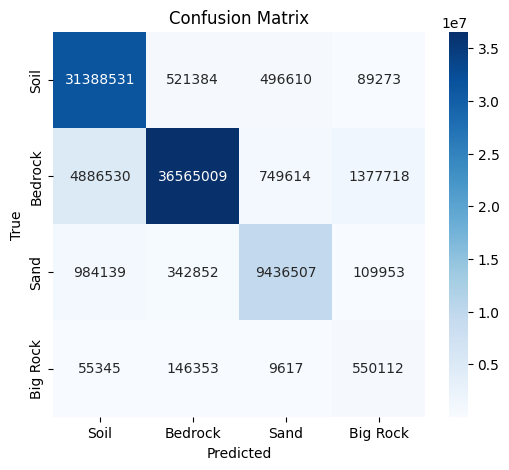

Per-Class IoU:
  Soil: 0.8169
  Bedrock: 0.8200
  Sand: 0.7780
  Big Rock: 0.2353
Mean IoU: 0.6626


In [13]:
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your test split and define a DataLoader similar to how you do it for train/val
#    (Assuming you have test_split.json or something similar).
test_split_path = os.path.join(BASE_PATH, "test_split.json")

# Example RealMarsDataset usage for the test set (reusing the same class from your code)
test_split_data = load_splits(test_split_path)
test_dataset = RealMarsDataset(test_split_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 2. Load the trained model and set it to eval mode
model = ResNet50(num_classes=NUM_CLASSES)
model_path = os.path.join(SAVED_MODEL_DIR, 'ResNet50_2.pth')
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# 3. Inference on the test set and gather predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks, _ in test_loader:  # We don't necessarily need masks_one_hot for evaluation
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(dim=1)  # shape: (batch_size, H, W)

        # Move to CPU
        preds_np  = preds.cpu().numpy()
        masks_np  = masks.cpu().numpy()

        # Flatten them, but exclude the -1 ignore pixels
        for i in range(preds_np.shape[0]):
            valid_indices = (masks_np[i] != -1)  # mask is -1 => ignore
            valid_preds   = preds_np[i][valid_indices]
            valid_targets = masks_np[i][valid_indices]
            all_preds.extend(valid_preds.tolist())
            all_targets.extend(valid_targets.tolist())

# 4. Classification report (multi-class)
#    We specify the class indices and their names for interpretability:
class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]
report = classification_report(
    all_targets,
    all_preds,
    labels=[0, 1, 2, 3],
    target_names=class_names,
    digits=4
)
print("Classification Report:")
print(report)

# 5. Confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Compute class-wise and mean IoU
#    We can adapt the mean_iou approach to aggregated data here
def compute_iou(preds, targets, num_classes):
    """
    preds: list or 1D array of predicted class indices
    targets: list or 1D array of ground truth class indices
    Returns: array of IoU values for each class, plus mean IoU
    """
    ious = []
    for cls in range(num_classes):
        intersection = 0
        union = 0
        for p, t in zip(preds, targets):
            intersection += int(p == cls and t == cls)
            union        += int((p == cls) or (t == cls))
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

ious = compute_iou(all_preds, all_targets, NUM_CLASSES)
print("Per-Class IoU:")
for idx, iou_val in enumerate(ious):
    print(f"  {class_names[idx]}: {iou_val:.4f}")
mean_iou = np.nanmean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

Segmentation map prediction

Selected Image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_626267617EDR_F0771560NCAM00263M1.JPG
Ground Truth Label: C:/Users/User/Desktop/ai4mars/msl\labels\train\NLB_626267617EDR_F0771560NCAM00263M1.png
Initializing ResNet50 with dropout=0.2
Initializing ResNet50Decoder with dropout=0.2


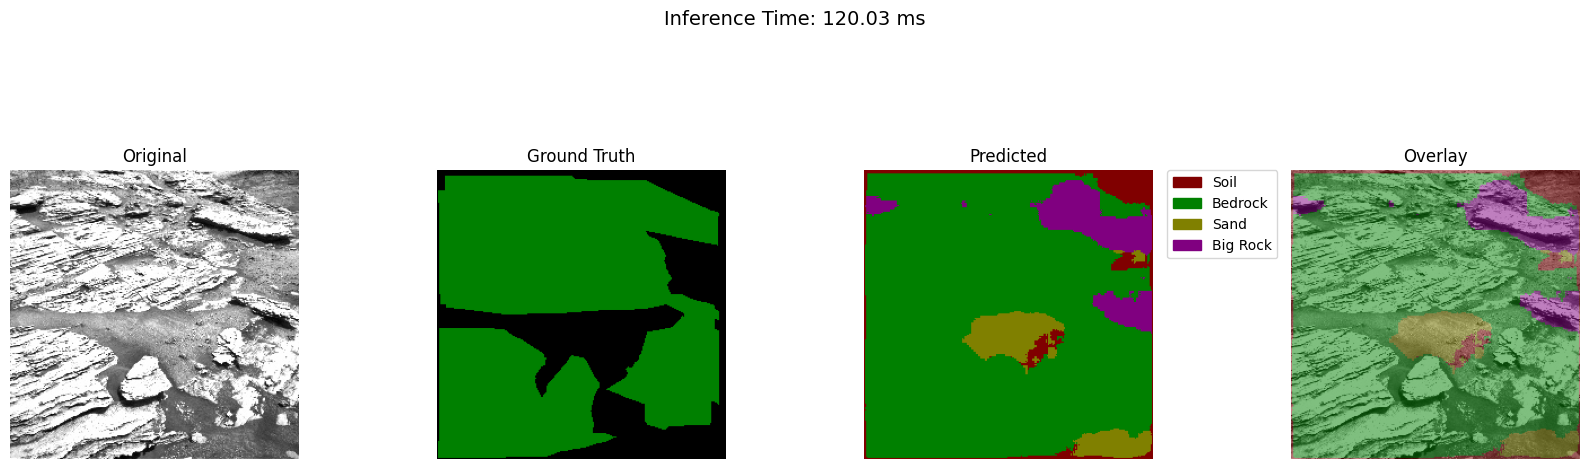

In [20]:
import os
import json
import time
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


BASE_PATH       = "C:/Users/User/Desktop/ai4mars/msl"
TEST_SPLIT      = os.path.join(BASE_PATH, "test_split.json")
SAVED_MODEL_DIR = "C:/Users/User/Desktop/saved_model"
MODEL_PATH      = os.path.join(SAVED_MODEL_DIR, "ResNet50_2.pth")

NUM_CLASSES     = 4
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]

# Consistent BGR color map for display
color_map = {
    0: (0, 0, 128),    # Soil
    1: (0, 128, 0),    # Bedrock
    2: (0, 128, 128),  # Sand
    3: (128, 0, 128),  # Big Rock
}

def load_test_split(test_split_path):
    with open(test_split_path, 'r') as f:
        return json.load(f)

def load_preprocess_single_image(img_path):
    """Load an image, resize to 256x256, normalize [0..1], and convert to Tensor(C,H,W)."""
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        image = np.zeros((256, 256, 3), dtype=np.float32)
    else:
        image = image.astype(np.float32) / 255.0
        image = cv2.resize(image, (256, 256))
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float()
    return image_tensor

def load_ground_truth_mask(mask_path):
    """Load ground-truth mask, resize, and return as (H,W) integer array."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
    else:
        mask = mask.astype(np.int64)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    return mask

def colorize_mask(mask):
    """
    Convert class indices in 'mask' to a BGR color image using 'color_map'.
    mask shape: (H, W), integer class IDs.
    Returns: (H,W,3) colored image.
    """
    h, w = mask.shape
    seg_vis = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, bgr in color_map.items():
        seg_vis[mask == cls_idx] = bgr
    return seg_vis

def main():
    # 1. Load test split
    test_data = load_test_split(TEST_SPLIT)
    if not test_data:
        raise ValueError("Test split is empty or missing.")

    # 2. Select an image from the test split
    image_id = 1239
    if image_id < 0 or image_id >= len(test_data):
        raise ValueError(f"Invalid image_id: {image_id}, must be between 0 and {len(test_data)-1}.")

    sample = test_data[image_id]
    image_path = sample["image"]
    mask_path  = sample["mask"]  # Ground-truth label path

    print(f"Selected Image: {image_path}")
    print(f"Ground Truth Label: {mask_path}")

    # 3. Load the trained ERFNet model
    model = ResNet50(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # 4. Preprocess the single image
    image_tensor = load_preprocess_single_image(image_path).unsqueeze(0).to(DEVICE)

    # Load original BGR image for display
    original_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_bgr is None:
        original_bgr = np.zeros((256, 256, 3), dtype=np.uint8)
    else:
        original_bgr = cv2.resize(original_bgr, (256, 256))

    # Load ground truth mask
    gt_mask = load_ground_truth_mask(mask_path)  # shape [256,256], class IDs
    gt_color = colorize_mask(gt_mask)

    # 5. Inference and measure time
    start_time = time.time()
    with torch.no_grad():
        output = model(image_tensor)  # shape [1, num_classes, 256,256]
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000

    # 6. Convert to predicted mask
    pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()
    pred_color = colorize_mask(pred_mask)

    # 7. Visualization
    # For clarity, we display 4 subplots: (1) original, (2) ground-truth, (3) predicted, (4) overlay
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    gt_rgb       = cv2.cvtColor(gt_color, cv2.COLOR_BGR2RGB)
    pred_rgb     = cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)

    # Overlay: blend original and predicted
    overlay_bgr = cv2.addWeighted(original_bgr, 0.5, pred_color, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    # Build legend patches
    patches = []
    for i, name in enumerate(class_names):
        b, g, r = color_map[i]
        color_rgb = (r/255, g/255, b/255)
        patches.append(mpatches.Patch(color=color_rgb, label=name))

    plt.figure(figsize=(16, 6))

    # Subplot 1: Original
    plt.subplot(1, 4, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis('off')

    # Subplot 2: Ground Truth
    plt.subplot(1, 4, 2)
    plt.imshow(gt_rgb)
    plt.title("Ground Truth")
    plt.axis('off')

    # Subplot 3: Predicted
    plt.subplot(1, 4, 3)
    plt.imshow(pred_rgb)
    plt.title("Predicted")
    plt.axis('off')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Subplot 4: Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(overlay_rgb)
    plt.title("Overlay")
    plt.axis('off')

    plt.suptitle(f"Inference Time: {inference_time_ms:.2f} ms", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# ResNet50 3

Initializing ResNet50 with dropout=0.2


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.6MB/s]


Initializing ResNet50Decoder with dropout=0.2


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/15 [Val]: 100%|██████████| 151/151 [05:41<00:00,  2.26s/it]


[Epoch 1/15] Train Loss: 2.5830, Train Acc: 0.7754, Val Loss: 2.0676, Val Acc: 0.9176, LR: 0.000099
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 2/15 [Val]: 100%|██████████| 151/151 [05:44<00:00,  2.28s/it]


[Epoch 2/15] Train Loss: 2.1731, Train Acc: 0.8522, Val Loss: 1.9274, Val Acc: 0.9239, LR: 0.000096
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 3/15 [Val]: 100%|██████████| 151/151 [05:40<00:00,  2.26s/it]


[Epoch 3/15] Train Loss: 2.0446, Train Acc: 0.8725, Val Loss: 1.8898, Val Acc: 0.9232, LR: 0.000091
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 4/15 [Val]: 100%|██████████| 151/151 [05:36<00:00,  2.23s/it]


[Epoch 4/15] Train Loss: 1.9728, Train Acc: 0.8880, Val Loss: 1.8260, Val Acc: 0.9363, LR: 0.000084
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 5/15 [Val]: 100%|██████████| 151/151 [05:43<00:00,  2.27s/it]


[Epoch 5/15] Train Loss: 1.9175, Train Acc: 0.8990, Val Loss: 1.8057, Val Acc: 0.9386, LR: 0.000075
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 6/15 [Val]: 100%|██████████| 151/151 [05:46<00:00,  2.29s/it]


[Epoch 6/15] Train Loss: 1.8641, Train Acc: 0.9123, Val Loss: 1.8071, Val Acc: 0.9383, LR: 0.000066


Epoch 7/15 [Val]: 100%|██████████| 151/151 [05:45<00:00,  2.29s/it]


[Epoch 7/15] Train Loss: 1.8279, Train Acc: 0.9221, Val Loss: 1.8102, Val Acc: 0.9404, LR: 0.000056


Epoch 8/15 [Val]: 100%|██████████| 151/151 [06:15<00:00,  2.49s/it]


[Epoch 8/15] Train Loss: 1.8039, Train Acc: 0.9254, Val Loss: 1.7795, Val Acc: 0.9440, LR: 0.000045
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 9/15 [Val]: 100%|██████████| 151/151 [05:45<00:00,  2.29s/it]


[Epoch 9/15] Train Loss: 1.7738, Train Acc: 0.9332, Val Loss: 1.7671, Val Acc: 0.9390, LR: 0.000035
Model saved to C:/Users/User/Desktop/saved_model\ResNet50_3.pth


Epoch 10/15 [Val]: 100%|██████████| 151/151 [05:46<00:00,  2.29s/it]


[Epoch 10/15] Train Loss: 1.7500, Train Acc: 0.9387, Val Loss: 1.7911, Val Acc: 0.9453, LR: 0.000026


Epoch 11/15 [Val]: 100%|██████████| 151/151 [05:42<00:00,  2.27s/it]


[Epoch 11/15] Train Loss: 1.7315, Train Acc: 0.9430, Val Loss: 1.7849, Val Acc: 0.9447, LR: 0.000017


Epoch 12/15 [Val]: 100%|██████████| 151/151 [05:48<00:00,  2.31s/it]


[Epoch 12/15] Train Loss: 1.7192, Train Acc: 0.9460, Val Loss: 1.7914, Val Acc: 0.9488, LR: 0.000010


Epoch 13/15 [Val]: 100%|██████████| 151/151 [05:58<00:00,  2.38s/it]


[Epoch 13/15] Train Loss: 1.7048, Train Acc: 0.9480, Val Loss: 1.7868, Val Acc: 0.9454, LR: 0.000005


Epoch 14/15 [Val]: 100%|██████████| 151/151 [05:42<00:00,  2.27s/it]


[Epoch 14/15] Train Loss: 1.6974, Train Acc: 0.9496, Val Loss: 1.7927, Val Acc: 0.9475, LR: 0.000002
Early stopping triggered. No improvement in validation loss.


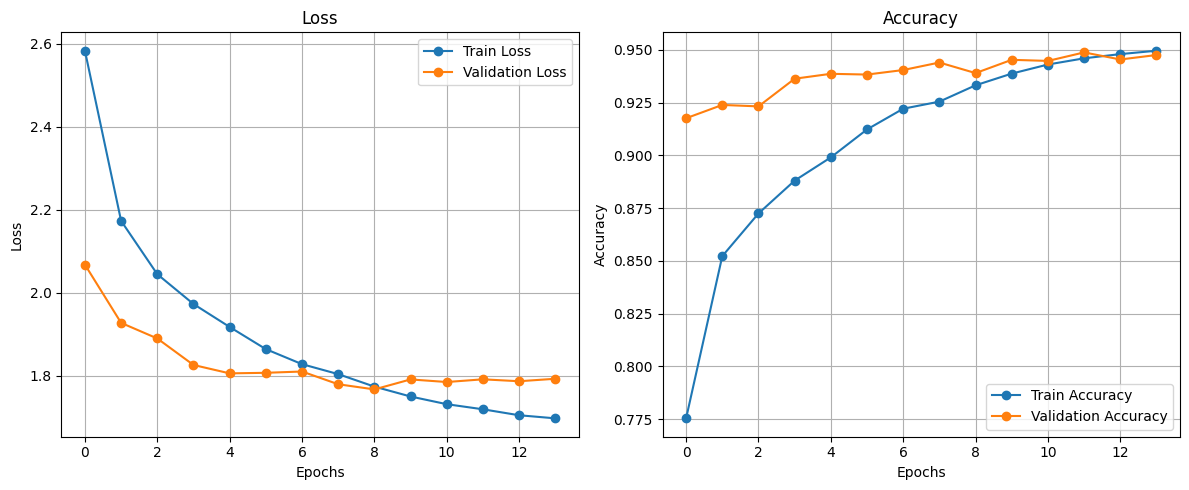

Training complete. Results have been saved.


In [3]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import torch.optim as optim
from glob import glob
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from torchvision.models.resnet import ResNet, Bottleneck
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.models as tvmodels

# ------------------- CONFIG -------------------
BASE_PATH = "C:/Users/User/Desktop/ai4mars/msl"
TRAIN_SPLIT = os.path.join(BASE_PATH, 'train_split.json')
VAL_SPLIT   = os.path.join(BASE_PATH, 'val_split.json')
CLASS_WEIGHTS_PATH = os.path.join(BASE_PATH, 'class_weights.json')
SAVED_MODEL_DIR    = "C:/Users/User/Desktop/saved_model"
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

NUM_CLASSES        = 4   # Soil, Bedrock, Sand, Big Rock
BATCH_SIZE         = 16
EPOCHS             = 15
LEARNING_RATE      = 1e-4
L2_REGULARIZATION  = 1e-5
PATIENCE           = 5

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------------------------------------
# ----------------- DATA LOADING -------------
def load_splits(split_path):
    with open(split_path, 'r') as f:
        return json.load(f)

train_split = load_splits(TRAIN_SPLIT)
val_split   = load_splits(VAL_SPLIT)

# Load class weights
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_json = json.load(f)
class_weights = torch.tensor(class_weights_json["class_weights"], dtype=torch.float32)

class RealMarsDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list[dict]): List of dictionaries with 'image' and 'mask' keys
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Read image and mask paths
        image_path = self.data[idx]['image']
        mask_path  = self.data[idx]['mask']

        # Load and preprocess image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            image = np.zeros((256, 256, 3), dtype=np.float32)
        else:
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, (256, 256))
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()  # (C,H,W)

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
        else:
            mask = mask.astype(np.int64)
            mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Replace 255 with -1 for ignore index
        mask[mask == 255] = -1

        # Create one-hot encoding (not strictly needed if using cross-entropy with ignore_index)
        mask_one_hot = torch.zeros((NUM_CLASSES, mask.shape[0], mask.shape[1]), dtype=torch.float32)
        for c in range(NUM_CLASSES):
            mask_class = (mask == c).astype(np.float32)
            mask_one_hot[c] = torch.from_numpy(mask_class)

        return image, torch.tensor(mask, dtype=torch.long), mask_one_hot

# Load splits
train_data = load_splits(TRAIN_SPLIT)
val_data   = load_splits(VAL_SPLIT)
train_dataset = RealMarsDataset(train_data)
val_dataset   = RealMarsDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---------------------------------------------
# ---------- HYBRID LOSS ---------------------
def hybrid_loss(pred, target, target_one_hot, class_weights, ignore_index=-1):
    import torch.nn as nn
    # Weighted Cross Entropy
    valid_target = target.clone()
    valid_target[valid_target == ignore_index] = 0
    wce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)(pred, valid_target)

    pred_softmax = F.softmax(pred, dim=1)

    # Dice
    dice_num = 2.0 * (pred_softmax * target_one_hot).sum(dim=(2, 3))
    dice_den = (pred_softmax + target_one_hot).sum(dim=(2, 3)) + 1e-6
    dice_loss = 1.0 - (dice_num / dice_den).mean()

    # Tversky
    alpha, beta = 0.7, 0.3
    tp = (pred_softmax * target_one_hot).sum(dim=(2,3))
    fn = (target_one_hot * (1 - pred_softmax)).sum(dim=(2,3))
    fp = ((1 - target_one_hot) * pred_softmax).sum(dim=(2,3))
    tversky_idx = tp / (tp + alpha*fn + beta*fp + 1e-6)
    tversky_loss = 1.0 - tversky_idx.mean()

    # Focal
    focal_loss = -(target_one_hot * ((1 - pred_softmax)**2) * torch.log(pred_softmax+1e-6)).mean()

    return wce_loss + dice_loss + tversky_loss + focal_loss

# ---------------------------------------------
#  CUSTOM BOTTLENECK BLOCK with DROPOUT
# ---------------------------------------------
class BottleneckWithDropout(Bottleneck):
    """
    Extend the standard ResNet Bottleneck block to include dropout=0.2
    after the second 3x3 conv, for moderate regularization.
    """
    def __init__(self, inplanes, planes, *args, **kwargs):
        dropout = kwargs.pop('dropout', 0.2)  # Default dropout to 0.2 if not provided
        super().__init__(inplanes, planes, *args, **kwargs)
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(p=self.dropout_rate)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # Insert dropout
        out = self.dropout(out)

        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ---------------------------------------------
#  ResNet-50 Encoder with layer4 (Dropout)
# ---------------------------------------------
from torchvision.models.resnet import ResNet

class ResNet50Encoder(ResNet):
    """
    A ResNet-50-based encoder that uses BottleneckWithDropout,
    optionally loading official ImageNet weights (for matching layers).
    The final FC and avgpool layers are removed (we do not need them).
    """
    def __init__(self, pretrained=True, dropout=0.2):
        # Use our custom bottleneck. Typical layers=[3,4,6,3] for ResNet-50
        super().__init__(block=BottleneckWithDropout, layers=[3,4,6,3], zero_init_residual=False)

        # Remove classification heads
        del self.fc
        del self.avgpool

        # If we want pretrained weights from standard resnet50
        if pretrained:
            # Create an official TorchVision resnet50
            official_resnet = tvmodels.resnet50(pretrained=True)
            official_dict   = official_resnet.state_dict()

            # Get our current model dict
            model_dict = self.state_dict()
            # Filter out keys that do not match or have differing shapes
            filtered_dict = {}
            for k, v in official_dict.items():
                # If the key matches one in our model and has the same shape, we can load it
                if k in model_dict and v.shape == model_dict[k].shape:
                    filtered_dict[k] = v

            # Update our model_dict with these pretrained weights
            model_dict.update(filtered_dict)
            self.load_state_dict(model_dict)

        # Overwrite each Bottleneck's dropout param if needed
        # (The 'args' in the super() call sets it for each block as well.)

    def forward(self, x):
        """
        Return f1, f2, f3, f4 for skip connections:
         f1 => layer1 output
         f2 => layer2
         f3 => layer3
         f4 => layer4
        """
        x = self.conv1(x)          # => [B,64,H/2,W/2]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)        # => [B,64,H/4,W/4]

        f1 = self.layer1(x)        # => [B,256,H/4,W/4]
        f2 = self.layer2(f1)       # => [B,512,H/8,W/8]
        f3 = self.layer3(f2)       # => [B,1024,H/16,W/16]
        f4 = self.layer4(f3)       # => [B,2048,H/32,W/32]

        return f1, f2, f3, f4

# ---------------------------------------------
#  Decoder with Dropout + Reduced Channels
# ---------------------------------------------
class ResNet50Decoder(nn.Module):
    """
    A decoder that expects f4=2048 channels from layer4, 
    but we reduce the upsample channels 'slightly' from 
    typical 512->256->128->64->32 to a narrower approach, 
    plus dropout=0.2 after each up conv for extra regularization.
    """
    def __init__(self, num_classes=4, dropout=0.2):
        print(f"Initializing ResNet50Decoder with dropout={dropout}")
        assert 0 <= dropout <= 1, f"Invalid dropout value: {dropout}"
        super().__init__()

        # up1 => 2048 -> 384 (reduce channels before merging with f3)
        self.up1 = nn.ConvTranspose2d(2048, 384, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(384)
        self.drop1 = nn.Dropout2d(p=dropout)

        # Merge f3=1024 => unify => e.g. 384+1024=1408 => unify to 384
        self.merge1 = nn.Conv2d(384+1024, 384, kernel_size=1, bias=False)
        self.merge1_bn = nn.BatchNorm2d(384)

        # up2 => 384->192 => [B,192,H/8,W/8]
        self.up2 = nn.ConvTranspose2d(384, 192, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(192)
        self.drop2 = nn.Dropout2d(p=dropout)

        # Merge f2=512 => unify => 192+512=704 => unify->192
        self.merge2 = nn.Conv2d(192+512, 192, kernel_size=1, bias=False)
        self.merge2_bn = nn.BatchNorm2d(192)

        # up3 => 192->96 => [B,96,H/4,W/4]
        self.up3 = nn.ConvTranspose2d(192, 96, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(96)
        self.drop3 = nn.Dropout2d(p=dropout)

        # Merge f1=256 => unify => 96+256=352 => unify->96
        self.merge3 = nn.Conv2d(96+256, 96, kernel_size=1, bias=False)
        self.merge3_bn = nn.BatchNorm2d(96)

        # up4 => 96->48 => [B,48,H/2,W/2]
        self.up4 = nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(48)
        self.drop4 = nn.Dropout2d(p=dropout)

        # up5 => 48->32 => [B,32,H,W] => (256×256)
        self.up5 = nn.ConvTranspose2d(48, 32, 4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.drop5 = nn.Dropout2d(p=dropout)

        # final => [B,num_classes,256,256]
        self.output_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, f1, f2, f3, f4):
        """
        f4 => [B,2048,H/32,W/32]
        f3 => [B,1024,H/16,W/16]
        f2 => [B,512,H/8,W/8]
        f1 => [B,256,H/4,W/4]
        """
        # up1 => => [B,384,H/16,W/16]
        x = self.up1(f4)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.drop1(x)

        # merge f3 => => unify -> shape [B,384,H/16,W/16]
        x = torch.cat([x, f3], dim=1)   # => [B,384+1024=1408,H/16,W/16]
        x = self.merge1(x)
        x = self.merge1_bn(x)
        x = F.relu(x, inplace=True)

        # up2 => => [B,192,H/8,W/8]
        x = self.up2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.drop2(x)

        # merge f2 => => [B,192,H/8,W/8]
        x = torch.cat([x, f2], dim=1)  # => [B,192+512=704,H/8,W/8]
        x = self.merge2(x)
        x = self.merge2_bn(x)
        x = F.relu(x, inplace=True)

        # up3 => => [B,96,H/4,W/4]
        x = self.up3(x)
        x = self.bn3(x)
        x = F.relu(x, inplace=True)
        x = self.drop3(x)

        # merge f1 => => [B,96,H/4,W/4]
        x = torch.cat([x, f1], dim=1)  # => [B,96+256=352,H/4,W/4]
        x = self.merge3(x)
        x = self.merge3_bn(x)
        x = F.relu(x, inplace=True)

        # up4 => => [B,48,H/2,W/2]
        x = self.up4(x)
        x = self.bn4(x)
        x = F.relu(x, inplace=True)
        x = self.drop4(x)

        # up5 => => [B,32,H,W] => 256×256
        x = self.up5(x)
        x = self.bn5(x)
        x = F.relu(x, inplace=True)
        x = self.drop5(x)

        logits = self.output_conv(x)
        return logits

# ---------------------------------------------
#    Final ResNet50 with Full Encoder
# ---------------------------------------------
class ResNet50(nn.Module):
    """
    A semantic segmentation model:
      - Full ResNet-50 encoder with layer4
      - Dropout in Bottleneck blocks (0.2)
      - Slightly narrower decoder with dropout
    """
    def __init__(self, num_classes=4):
        super().__init__()
        dropout = 0.2  # Ensure a valid value
        print(f"Initializing ResNet50 with dropout={dropout}")
        self.encoder = ResNet50Encoder(dropout=dropout)
        self.decoder = ResNet50Decoder(num_classes=num_classes, dropout=dropout)

    def forward(self, x):
        f1, f2, f3, f4 = self.encoder(x)
        logits = self.decoder(f1, f2, f3, f4)
        return logits

# ---------------------------------------------
#         TRAIN FUNCTION (Cosine LR)
# ---------------------------------------------
def train_model(
    model, train_loader, val_loader,
    num_epochs, save_path,
    base_lr=1e-4,  # initial LR
    l2_reg=1e-7,
    early_stopping_patience=5
):
    import torch.optim as optim
    from torch.optim.lr_scheduler import CosineAnnealingLR

    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=l2_reg)

    # Setup Cosine Annealing LR for 'num_epochs' cycles
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    def mean_iou(pred, target, num_classes):
        pred_labels = torch.argmax(pred, dim=1)
        ious = []
        for cls in range(num_classes):
            intersection = ((pred_labels == cls) & (target == cls)).sum().item()
            union = ((pred_labels == cls) | (target == cls)).sum().item()
            if union > 0:
                ious.append(intersection / union)
        return np.mean(ious) if ious else 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, masks, masks_one_hot in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = hybrid_loss(outputs, masks, masks_one_hot, class_weights)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = outputs.argmax(dim=1)
            valid_indices = (masks != -1)
            train_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
            train_total   += valid_indices.sum().item()

        # Metrics for training
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total if train_total>0 else 0.0

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, masks, masks_one_hot in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, masks, masks_one_hot = images.to(DEVICE), masks.to(DEVICE), masks_one_hot.to(DEVICE)
                outputs = model(images)
                loss = hybrid_loss(outputs, masks, masks_one_hot, class_weights)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                valid_indices = (masks != -1)
                val_correct += (preds[valid_indices] == masks[valid_indices]).sum().item()
                val_total   += valid_indices.sum().item()

        val_loss     /= len(val_loader)
        val_accuracy = val_correct / val_total if val_total>0 else 0.0

        # Cosine LR step after each epoch
        scheduler.step()

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path}")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

    return history


# ---------------- PLOT LEARNING CURVES --------------
def plot_learning_curves(history):
    """Plot training and validation loss, accuracy using the stored `history` dict."""
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label="Train Loss", marker='o')
    plt.plot(history['val_loss'], label="Validation Loss", marker='o')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label="Train Accuracy", marker='o')
    plt.plot(history['val_accuracy'], label="Validation Accuracy", marker='o')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# ---------------- MAIN SCRIPT ----------------
if __name__ == "__main__":
    model = ResNet50(num_classes=NUM_CLASSES)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_REGULARIZATION)

    # Setup ReduceLROnPlateau
    reduce_on_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-10, verbose=1)

    # Train
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        save_path=os.path.join(SAVED_MODEL_DIR, 'ResNet50_3.pth'),
        base_lr=LEARNING_RATE,
        l2_reg=L2_REGULARIZATION,
        early_stopping_patience=PATIENCE
    )

    # Plot the final learning curves
    plot_learning_curves(history)

    print("Training complete. Results have been saved.")

Model evaluation

Initializing ResNet50 with dropout=0.2


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing ResNet50Decoder with dropout=0.2
Classification Report:
              precision    recall  f1-score   support

        Soil     0.9042    0.9802    0.9407  32495798
     Bedrock     0.9876    0.9137    0.9492  43578871
        Sand     0.9381    0.9298    0.9339  10873451
    Big Rock     0.4820    0.8758    0.6218    761427

    accuracy                         0.9400  87709547
   macro avg     0.8279    0.9249    0.8614  87709547
weighted avg     0.9461    0.9400    0.9413  87709547



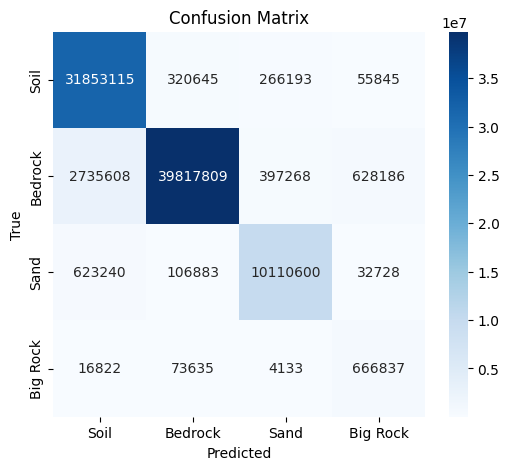

Per-Class IoU:
  Soil: 0.8880
  Bedrock: 0.9033
  Sand: 0.8761
  Big Rock: 0.4511
Mean IoU: 0.7796


In [4]:
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your test split and define a DataLoader similar to how you do it for train/val
#    (Assuming you have test_split.json or something similar).
test_split_path = os.path.join(BASE_PATH, "test_split.json")

# Example RealMarsDataset usage for the test set (reusing the same class from your code)
test_split_data = load_splits(test_split_path)
test_dataset = RealMarsDataset(test_split_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 2. Load the trained model and set it to eval mode
model = ResNet50(num_classes=NUM_CLASSES)
model_path = os.path.join(SAVED_MODEL_DIR, 'ResNet50_3.pth')
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# 3. Inference on the test set and gather predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks, _ in test_loader:  # We don't necessarily need masks_one_hot for evaluation
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        outputs = model(images)
        preds = outputs.argmax(dim=1)  # shape: (batch_size, H, W)

        # Move to CPU
        preds_np  = preds.cpu().numpy()
        masks_np  = masks.cpu().numpy()

        # Flatten them, but exclude the -1 ignore pixels
        for i in range(preds_np.shape[0]):
            valid_indices = (masks_np[i] != -1)  # mask is -1 => ignore
            valid_preds   = preds_np[i][valid_indices]
            valid_targets = masks_np[i][valid_indices]
            all_preds.extend(valid_preds.tolist())
            all_targets.extend(valid_targets.tolist())

# 4. Classification report (multi-class)
#    We specify the class indices and their names for interpretability:
class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]
report = classification_report(
    all_targets,
    all_preds,
    labels=[0, 1, 2, 3],
    target_names=class_names,
    digits=4
)
print("Classification Report:")
print(report)

# 5. Confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Compute class-wise and mean IoU
#    We can adapt the mean_iou approach to aggregated data here
def compute_iou(preds, targets, num_classes):
    """
    preds: list or 1D array of predicted class indices
    targets: list or 1D array of ground truth class indices
    Returns: array of IoU values for each class, plus mean IoU
    """
    ious = []
    for cls in range(num_classes):
        intersection = 0
        union = 0
        for p, t in zip(preds, targets):
            intersection += int(p == cls and t == cls)
            union        += int((p == cls) or (t == cls))
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

ious = compute_iou(all_preds, all_targets, NUM_CLASSES)
print("Per-Class IoU:")
for idx, iou_val in enumerate(ious):
    print(f"  {class_names[idx]}: {iou_val:.4f}")
mean_iou = np.nanmean(ious)
print(f"Mean IoU: {mean_iou:.4f}")

Segmentation map prediction

Selected Image: C:/Users/User/Desktop/ai4mars/msl\images\edr\NLB_626267617EDR_F0771560NCAM00263M1.JPG
Ground Truth Label: C:/Users/User/Desktop/ai4mars/msl\labels\train\NLB_626267617EDR_F0771560NCAM00263M1.png
Initializing ResNet50 with dropout=0.2
Initializing ResNet50Decoder with dropout=0.2


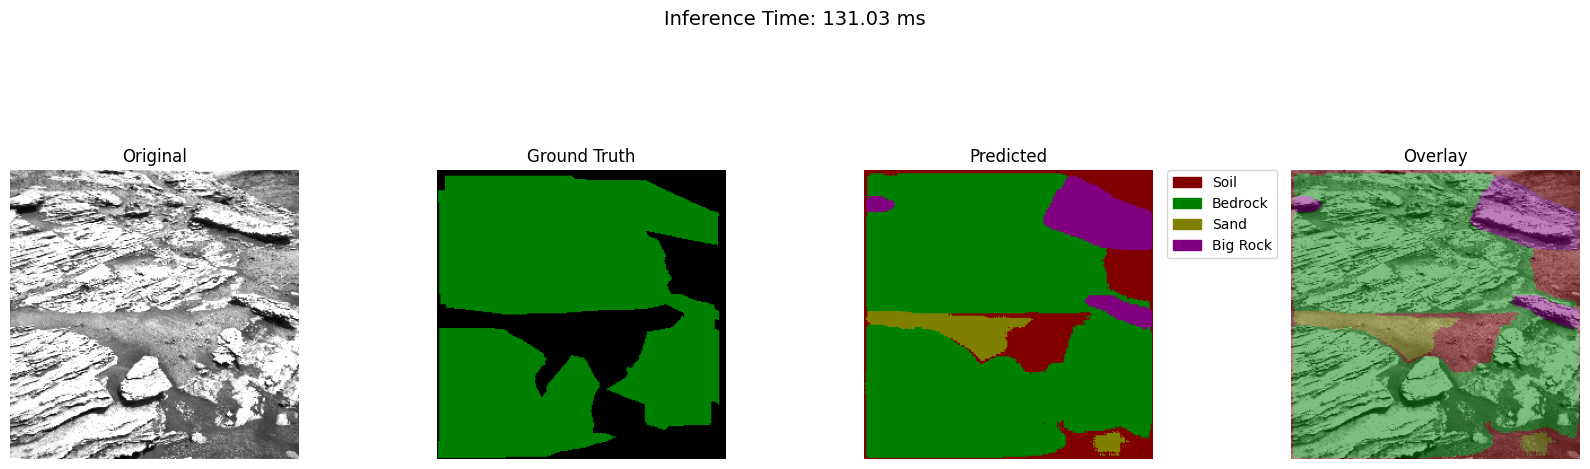

In [14]:
import os
import json
import time
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


BASE_PATH       = "C:/Users/User/Desktop/ai4mars/msl"
TEST_SPLIT      = os.path.join(BASE_PATH, "test_split.json")
SAVED_MODEL_DIR = "C:/Users/User/Desktop/saved_model"
MODEL_PATH      = os.path.join(SAVED_MODEL_DIR, "ResNet50_3.pth")

NUM_CLASSES     = 4
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_names = ["Soil", "Bedrock", "Sand", "Big Rock"]

# Consistent BGR color map for display
color_map = {
    0: (0, 0, 128),    # Soil
    1: (0, 128, 0),    # Bedrock
    2: (0, 128, 128),  # Sand
    3: (128, 0, 128),  # Big Rock
}

def load_test_split(test_split_path):
    with open(test_split_path, 'r') as f:
        return json.load(f)

def load_preprocess_single_image(img_path):
    """Load an image, resize to 256x256, normalize [0..1], and convert to Tensor(C,H,W)."""
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        image = np.zeros((256, 256, 3), dtype=np.float32)
    else:
        image = image.astype(np.float32) / 255.0
        image = cv2.resize(image, (256, 256))
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float()
    return image_tensor

def load_ground_truth_mask(mask_path):
    """Load ground-truth mask, resize, and return as (H,W) integer array."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        mask = np.full((256, 256), fill_value=-1, dtype=np.int64)
    else:
        mask = mask.astype(np.int64)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    return mask

def colorize_mask(mask):
    """
    Convert class indices in 'mask' to a BGR color image using 'color_map'.
    mask shape: (H, W), integer class IDs.
    Returns: (H,W,3) colored image.
    """
    h, w = mask.shape
    seg_vis = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, bgr in color_map.items():
        seg_vis[mask == cls_idx] = bgr
    return seg_vis

def main():
    # 1. Load test split
    test_data = load_test_split(TEST_SPLIT)
    if not test_data:
        raise ValueError("Test split is empty or missing.")

    # 2. Select an image from the test split
    image_id = 1239
    if image_id < 0 or image_id >= len(test_data):
        raise ValueError(f"Invalid image_id: {image_id}, must be between 0 and {len(test_data)-1}.")

    sample = test_data[image_id]
    image_path = sample["image"]
    mask_path  = sample["mask"]  # Ground-truth label path

    print(f"Selected Image: {image_path}")
    print(f"Ground Truth Label: {mask_path}")

    # 3. Load the trained ERFNet model
    model = ResNet50(num_classes=NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # 4. Preprocess the single image
    image_tensor = load_preprocess_single_image(image_path).unsqueeze(0).to(DEVICE)

    # Load original BGR image for display
    original_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if original_bgr is None:
        original_bgr = np.zeros((256, 256, 3), dtype=np.uint8)
    else:
        original_bgr = cv2.resize(original_bgr, (256, 256))

    # Load ground truth mask
    gt_mask = load_ground_truth_mask(mask_path)  # shape [256,256], class IDs
    gt_color = colorize_mask(gt_mask)

    # 5. Inference and measure time
    start_time = time.time()
    with torch.no_grad():
        output = model(image_tensor)  # shape [1, num_classes, 256,256]
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000

    # 6. Convert to predicted mask
    pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()
    pred_color = colorize_mask(pred_mask)

    # 7. Visualization
    # For clarity, we display 4 subplots: (1) original, (2) ground-truth, (3) predicted, (4) overlay
    original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
    gt_rgb       = cv2.cvtColor(gt_color, cv2.COLOR_BGR2RGB)
    pred_rgb     = cv2.cvtColor(pred_color, cv2.COLOR_BGR2RGB)

    # Overlay: blend original and predicted
    overlay_bgr = cv2.addWeighted(original_bgr, 0.5, pred_color, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    # Build legend patches
    patches = []
    for i, name in enumerate(class_names):
        b, g, r = color_map[i]
        color_rgb = (r/255, g/255, b/255)
        patches.append(mpatches.Patch(color=color_rgb, label=name))

    plt.figure(figsize=(16, 6))

    # Subplot 1: Original
    plt.subplot(1, 4, 1)
    plt.imshow(original_rgb)
    plt.title("Original")
    plt.axis('off')

    # Subplot 2: Ground Truth
    plt.subplot(1, 4, 2)
    plt.imshow(gt_rgb)
    plt.title("Ground Truth")
    plt.axis('off')

    # Subplot 3: Predicted
    plt.subplot(1, 4, 3)
    plt.imshow(pred_rgb)
    plt.title("Predicted")
    plt.axis('off')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Subplot 4: Overlay
    plt.subplot(1, 4, 4)
    plt.imshow(overlay_rgb)
    plt.title("Overlay")
    plt.axis('off')

    plt.suptitle(f"Inference Time: {inference_time_ms:.2f} ms", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()